In [1]:
import numpy as np

from fipy import (
    Grid2D,
    CellVariable,
    FaceVariable,
    DiffusionTerm,
    Viewer,
    numerix
)

In [2]:
L = 1.0 # Cavity dimensions
N = 50 # Number of divisions
dL = L / N # Cell sizes
viscosity = 1. # Consistency viscosity value. The value "C" from Ostwald fluid model.
m = 1.5 # First value of the behavior constant will set the case as Newtonian
eps = 0.025 # criteria to stop
U = 1.0 # upper boundary fluid velocity
#   0.4 for pressure and 0.02 for velocity worked fine for 0.5<=m<=1.5
#   worked for m=0.25
pressureRelaxation = 0.4
velocityRelaxation = 0.02 
Re = U ** (2 - m) * L ** m / viscosity # Added non-Newtonian Reynolds number calculation for reference
# the number of sweeps when explicit called is 300, when running as a test is 5
sweeps = 15000

In [3]:
mesh = Grid2D(nx=N, ny=N, dx=dL, dy=dL)

In [4]:
pressure = CellVariable(mesh=mesh, name='pressure')
pressureCorrection = CellVariable(mesh=mesh)
xVelocity = CellVariable(mesh=mesh, name='X velocity')
yVelocity = CellVariable(mesh=mesh, name='Y velocity')

In [5]:
velocity = FaceVariable(mesh=mesh, rank=1)

In [6]:
velocity_variable = CellVariable(mesh=mesh, name='vel_var',rank=1)

# need this to get through the first step without error
velocity_variable[:] = 1e-6 * np.random.random(velocity_variable.shape)

In [7]:
def trans2x2(var):
    # Transpose for  2 x 2 variable
    return [[1, 0], [0, 1]] * var + [[0, 1], [0, 0]] * var[1, 0] + [[0, 0], [1, 0]] * var[0, 1]

def mag2x2(var):
    # Magnitude for 2 x 2 variable
    return numerix.sqrt((var**2).sum(0).sum(0))

In [8]:
shear_strain = 0.5 * (velocity_variable.grad + trans2x2(velocity_variable.grad))

In [9]:
def xterm(mat):
    return viscosity * np.array(mat) * mag2x2(shear_strain) ** (m-1)

xTerm1 = xterm([[1, 0], [0, 1 / 2]])
xTerm2 = xterm([[0, 1 / 2], [0, 0]])
yTerm1 = xterm([[0, 0], [0, 1 / 2]])
yTerm2 = xterm([[1 / 2, 0], [0, 1]])

In [10]:
def xterm(mat):
    return viscosity * np.array(mat) * mag2x2(shear_strain) ** (m-1)

xTerm1 = xterm([[1, 0], [0, 1 / 2]])
xTerm2 = xterm([[0, 1 / 2], [0, 0]])
yTerm1 = xterm([[0, 0], [0, 1 / 2]])
yTerm2 = xterm([[1 / 2, 0], [0, 1]])

In [11]:
xVelocityEq = DiffusionTerm(xTerm1,var=xVelocity)+DiffusionTerm(xTerm2,var=yVelocity)-pressure.grad.dot([1., 0.])
yVelocityEq = DiffusionTerm(yTerm1,var=xVelocity)+DiffusionTerm(yTerm2,var=yVelocity)-pressure.grad.dot([0., 1.])

In [12]:
ap = CellVariable(mesh=mesh, value=1.)
coeff = 1. / ap.arithmeticFaceValue * mesh._faceAreas * mesh._cellDistances
pressureCorrectionEq = DiffusionTerm(coeff=coeff) - velocity.divergence

In [13]:
from fipy.variables.faceGradVariable import _FaceGradVariable
volume = CellVariable(mesh=mesh, value=mesh.cellVolumes, name='Volume')
contrvolume = volume.arithmeticFaceValue

In [14]:
xVelocity.constrain(0., mesh.facesRight | mesh.facesLeft | mesh.facesBottom)
xVelocity.constrain(U, mesh.facesTop)
yVelocity.constrain(0., mesh.exteriorFaces)
X, Y = mesh.faceCenters
pressureCorrection.constrain(0., mesh.facesLeft & (Y < dL))

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

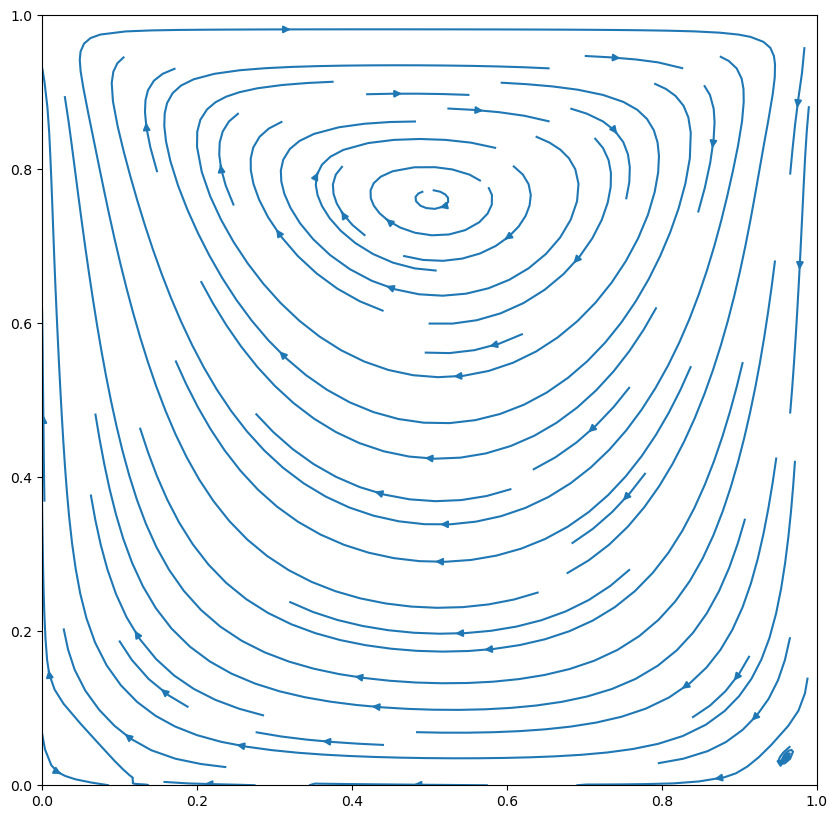

In [18]:
if __name__ == '__main__':
    try:
        from fipy.viewers.matplotlibViewer import MatplotlibStreamViewer
        viewer = MatplotlibStreamViewer(vars=(velocity),
                   xmin=0., xmax=1., ymin=0., ymax=1.);
    except:
        viewer = Viewer(vars=(velocity),
                   xmin=0., xmax=1., ymin=0., ymax=1., scale=5)        

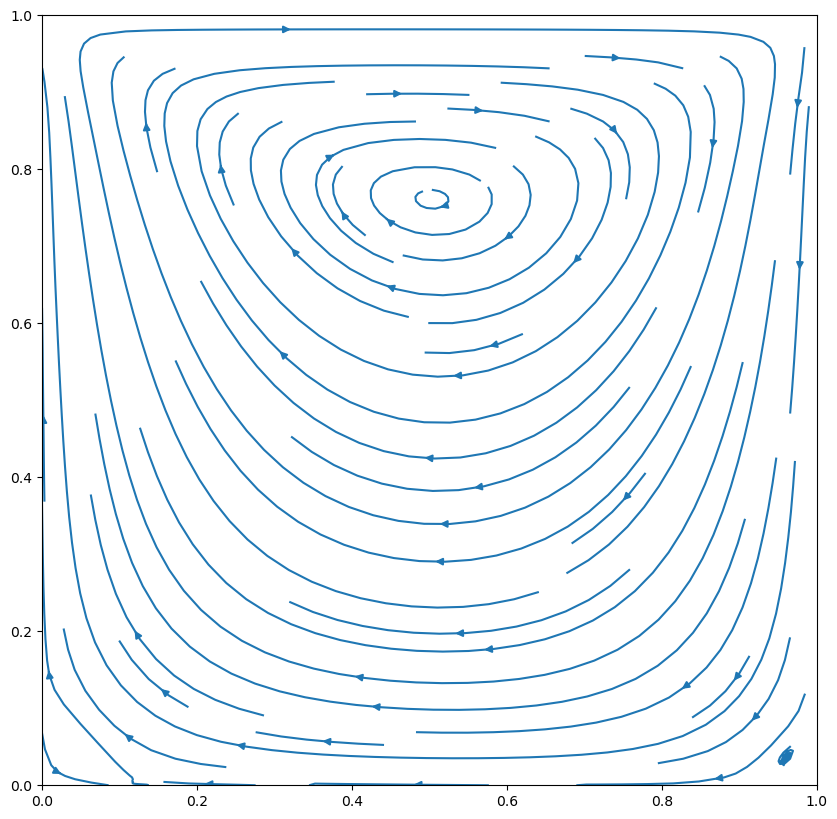

Residuals are less than: 0.025


<Figure size 1000x1000 with 0 Axes>

In [17]:
for sweep in range(sweeps):
# while min(xres,yres) > 0.01:
    
     ## solve the Stokes equations to get starred values
     xVelocityEq.cacheMatrix()
     
     # solving for x and y velocities
     
     xres = xVelocityEq.sweep(var=xVelocity,
                              underRelaxation=velocityRelaxation)
  
     xmat = xVelocityEq.matrix

     yres = yVelocityEq.sweep(var=yVelocity,
                              underRelaxation=velocityRelaxation)

     # solving again to adjust the x and y velocity values ########################
     xres = xVelocityEq.sweep(var=xVelocity,
                              underRelaxation=velocityRelaxation)
     xmat = xVelocityEq.matrix

     yres = yVelocityEq.sweep(var=yVelocity,
                              underRelaxation=velocityRelaxation)
     ############################################################################
     
    
     ## update the ap coefficient from the matrix diagonal
     ap[:] = -numerix.asarray(xmat.takeDiagonal())

     ## update the face velocities based on starred values with the
     ## Rhie-Chow correction.
     ## cell pressure gradient
     presgrad = pressure.grad
     ## face pressure gradient
     facepresgrad = _FaceGradVariable(pressure)

     velocity[0] = xVelocity.arithmeticFaceValue \
          + contrvolume / ap.arithmeticFaceValue \
          * (presgrad[0].arithmeticFaceValue-facepresgrad[0])
     velocity[1] = yVelocity.arithmeticFaceValue \
          + contrvolume / ap.arithmeticFaceValue \
          * (presgrad[1].arithmeticFaceValue-facepresgrad[1])
     velocity[..., mesh.exteriorFaces.value] = 0.
     velocity[0, mesh.facesTop.value] = U

     ## solve the pressure correction equation
     pressureCorrectionEq.cacheRHSvector()
     ## left bottom point must remain at pressure 0, so no correction
     pres = pressureCorrectionEq.sweep(var=pressureCorrection)
     rhs = pressureCorrectionEq.RHSvector

     ## update the pressure using the corrected value
     pressure.setValue(pressure + pressureRelaxation * pressureCorrection )
     ## update the velocity using the corrected pressure
     xVelocity.setValue(xVelocity - pressureCorrection.grad[0] \
                                  / ap * mesh.cellVolumes)
     yVelocity.setValue(yVelocity - pressureCorrection.grad[1] \
                                  / ap * mesh.cellVolumes)
     
     velocity_variable.setValue([xVelocity,yVelocity])

     if __name__ == '__main__':
         if sweep % 50 == 0:
             print('sweep:', sweep, ', x residual:', xres, \
                                    ', y residual',  yres, \
                                    ', p residual:', pres, \
                                    ', continuity:', max(abs(rhs)))
             plt.figure(num=1, figsize=(10,10))
     
             viewer.plot()

     # Criteria to stop
     if (max(xres, yres) < eps):
        print("Residuals are less than: {0}".format(eps))
        break        
     else:
        continue